In [1]:
# simulate the negative binomial distribution and do optimization to recover the alpha 
# 1) find weight MLE with known r
# 2) find all parameters
# add the normalizing constant negative-log-likelihood for possion and negative binomial to make it comparable

# Sanity Check


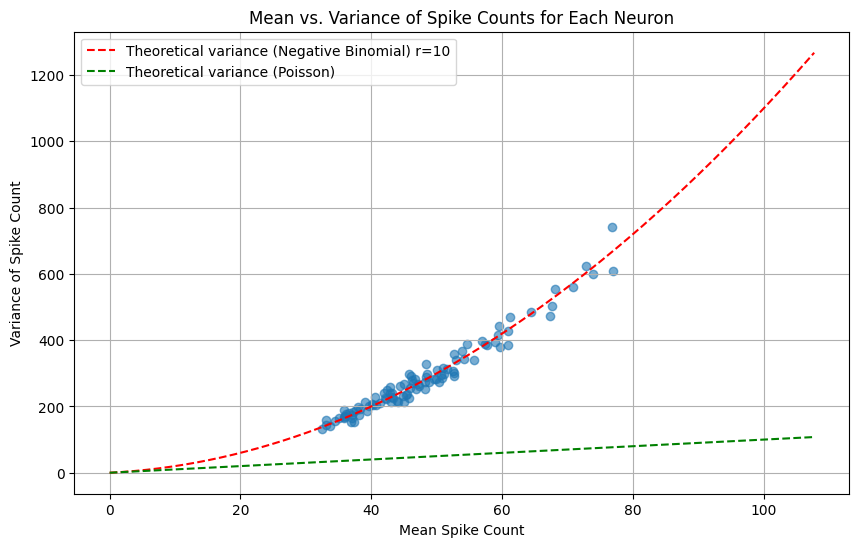

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)  # For reproducibility

# Parameters
n_neurons = 100  # Number of neurons
n_obs = 500  # Number of observations (different stimulus intensities)

# Stimulus variable: Light intensity ranging from 0 (no light) to 10 (maximum intensity)
light_intensity = np.linspace(0, 10, n_obs)

# Define relationship for expected spike count
# Assume the mean spike count increases linearly with the intensity of the light
beta_0 = 2  # Baseline spike count when there is no light
beta_1 = 0.3  # Increase in spike count for each unit increase in light intensity

# Define the dispersion parameter for the negative binomial distribution
dispersion = 10 # This affects the variance of the spike counts

spike_counts = np.zeros((n_neurons, n_obs))

for i in range(n_neurons):
    individual_effect = np.random.normal(0, 0.2)  # Random effect for each neuron
    
    # Calculate mean spike count using an exponential function to ensure non-negativity
    mean_spike_count = np.exp(beta_0 + beta_1 * light_intensity + individual_effect)
    
    # Calculate probability of success
    p = dispersion / (dispersion + np.mean(mean_spike_count))
    
    spike_counts[i, :] = np.random.negative_binomial(n=dispersion, p=p, size=n_obs)
    
# Calculate mean and variance for each neuron
mean_counts = np.mean(spike_counts, axis=1)
var_counts = np.var(spike_counts, axis=1)

# Plotting Mean vs. Variance
plt.figure(figsize=(10, 6))

mu_values = np.linspace(0, np.max(mean_counts)*1.4, 400)
p = dispersion / (dispersion + mu_values)
expected_variance = dispersion * (1-p)/p**2
# expected_variance = mu_values * ( 1 + mu_values / dispersion)
plt.plot(mu_values, expected_variance, 'r--', label='Theoretical variance (Negative Binomial) r=10')

# Theoretical variance curve for Poisson distribution
expected_variance_poisson = mu_values
plt.plot(mu_values, expected_variance_poisson, 'g--', label='Theoretical variance (Poisson)')

plt.scatter(mean_counts, var_counts, alpha=0.6)
plt.title('Mean vs. Variance of Spike Counts for Each Neuron')
plt.xlabel('Mean Spike Count')
plt.ylabel('Variance of Spike Count')
plt.grid(True)
plt.legend()
plt.show()

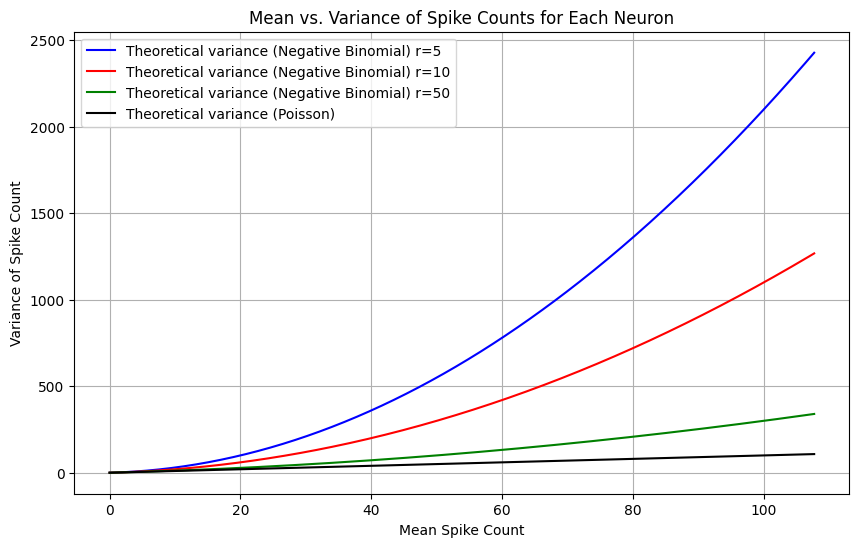

In [3]:
# Plotting Mean vs. Variance
plt.figure(figsize=(10, 6))


dispersion = 5
p = dispersion / (dispersion + mu_values)
expected_variance = dispersion * (1-p)/p**2
# expected_variance = mu_values * ( 1 + mu_values / dispersion)
plt.plot(mu_values, expected_variance, 'b', label='Theoretical variance (Negative Binomial) r=5')

dispersion = 10
mu_values = np.linspace(0, np.max(mean_counts)*1.4, 400)
p = dispersion / (dispersion + mu_values)
expected_variance = dispersion * (1-p)/p**2
# expected_variance = mu_values * ( 1 + mu_values / dispersion)
plt.plot(mu_values, expected_variance, 'r', label='Theoretical variance (Negative Binomial) r=10')

dispersion = 50
p = dispersion / (dispersion + mu_values)
expected_variance = dispersion * (1-p)/p**2
# expected_variance = mu_values * ( 1 + mu_values / dispersion)
plt.plot(mu_values, expected_variance, 'g', label='Theoretical variance (Negative Binomial) r=50')


expected_variance_poisson = mu_values
plt.plot(mu_values, expected_variance_poisson, 'black', label='Theoretical variance (Poisson)')


plt.title('Mean vs. Variance of Spike Counts for Each Neuron')
plt.xlabel('Mean Spike Count')
plt.ylabel('Variance of Spike Count')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
from scipy.special import gammaln, expit, logit
from scipy.optimize import minimize

def neg_binomial_loglik_known_r(params, X, y):
    beta = params
    dispersion = 2
        
    p_success = expit(X @ beta)
            
    term1 = gammaln(y + dispersion) - gammaln(y + 1) - gammaln(dispersion)
    epsilon = 1e-10
    term2 = y * np.log(p_success + epsilon)
    term3 = dispersion * np.log(1-p_success + epsilon)
    
    return -np.sum(term1 + term2 + term3)

def fit_model_known_r(X, y):
     # Initial guess for parameters
    init_params = [1, 1]

    # Minimize the negative log likelihood
    result = minimize(neg_binomial_loglik_known_r, init_params, args=(X, y))

    return result

X = np.vstack([np.ones(n_obs), light_intensity]).T  # include intercept

results = []

for i in range(n_neurons):
    y = spike_counts[i, :]
    result = fit_model_known_r(X, y)
    results.append(result)
    
NB_known_r_beta0_estimates = np.array([result.x[0] for result in results])   
NB_known_r_beta1_estimates = np.array([result.x[1] for result in results])  # Assuming 'results' is a list of optimization results
NB_known_r_nlli = np.array([result.fun for result in results])
print(NB_known_r_beta0_estimates.mean())
print(NB_known_r_beta1_estimates.mean())
print(NB_known_r_nlli.mean())

3.154036424122527
-0.0001982669124189766
2270.8184297159937


In [5]:
import statsmodels.api as sm
import statsmodels

design_mat_offset = np.vstack((np.ones((n_obs)), light_intensity)).T

def sm_fit_model_NB_logistic(X, y, alpha=0.1):
    glm_NB_logistic = sm.GLM(endog=y, exog=X, family=sm.families.NegativeBinomial(link=sm.families.links.Log(), alpha=alpha))
    pGLM_results = glm_NB_logistic.fit()
    return pGLM_results

results = []

for i in range(n_neurons):
    y = spike_counts[i, :]
    result = sm_fit_model_NB_logistic(design_mat_offset, y)
    results.append(result)
    
sm_NB_logistic_beta0_estimates = np.array([result.params[0] for result in results])   
sm_NB_logistic_beta1_estimates = np.array([result.params[1] for result in results])  # Assuming 'results' is a list of optimization results
sm_NB_logistic_nlli = np.array([result.llf for result in results])
print(sm_NB_logistic_beta0_estimates.mean())
print(sm_NB_logistic_beta1_estimates.mean())
print(-sm_NB_logistic_nlli.mean())

3.8471772189249047
-0.00019698607415164754
2089.164491433878


In [6]:
# import numpy as np
# from scipy.optimize import minimize

# def neg_poisson_exp_log_likelihood(w, X, Y):
#     z = np.exp(X @ w)
#     return -np.sum(Y * np.log(z) - z)

# def fit_model_poission_exp(X, y):
#      # Initial guess for parameters
#     init_params = [1, 1]

#     # Minimize the negative log likelihood
#     result = minimize(neg_poisson_exp_log_likelihood, init_params, args=(X, y))

#     return result

# X = np.vstack([np.ones(n_obs), light_intensity]).T  # include intercept

# results = []

# for i in range(n_neurons):
#     y = spike_counts[i, :]
#     result = fit_model_poission_exp(X, y)
#     results.append(result)
    
# poisson_exp_beta0_estimates = np.array([result.x[0] for result in results])   
# poisson_exp_beta1_estimates = np.array([result.x[1] for result in results])  # Assuming 'results' is a list of optimization results
# poisson_exp__nlli = np.array([result.fun for result in results])
# print(poisson_exp_beta0_estimates.mean())
# print(poisson_exp_beta1_estimates.mean())
# print(poisson_exp__nlli.mean())

In [7]:
import statsmodels.api as sm

design_mat_offset = np.vstack((np.ones((n_obs)), light_intensity)).T

def sm_fit_model_poission_exp(X, y):
    glm_poisson_exp = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())
    pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')
    return pGLM_results

results = []

for i in range(n_neurons):
    y = spike_counts[i, :]
    result = sm_fit_model_poission_exp(design_mat_offset, y)
    results.append(result)
    
sm_poisson_exp_beta0_estimates = np.array([result.params[0] for result in results])   
sm_poisson_exp_beta1_estimates = np.array([result.params[1] for result in results])  # Assuming 'results' is a list of optimization results
sm_poisson_exp__nlli = np.array([result.llf for result in results])
print(sm_poisson_exp_beta0_estimates.mean())
print(sm_poisson_exp_beta1_estimates.mean())
print(-sm_poisson_exp__nlli.mean())

3.847133206181977
-0.0001881753904278459
2833.7514029265735


In [8]:
from scipy.special import gammaln, expit
from scipy.optimize import minimize

def neg_binomial_loglik(params, X, y):
    beta = params[:-1]
    log_dispersion = params[-1]
    dispersion = np.exp(log_dispersion)
    
    p = expit(X @ beta)
    epsilon = 1e-10
        
    term1 = gammaln(y + dispersion) - gammaln(dispersion) - gammaln(y + 1)
    term2 = dispersion * np.log(1 - p + epsilon)
    term3 = y * np.log(p + epsilon)
    
    return -np.sum(term1 + term2 + term3)

def fit_NB_full_model(X, y):
    init_params = np.append(np.zeros(X.shape[1]), np.log(0.5)) # Last one is log(dispersion)

    # Minimize the negative log likelihood
    result = minimize(neg_binomial_loglik, init_params, args=(X, y))
    
    return result

X = np.vstack([np.ones(n_obs), light_intensity]).T 

results = []

for i in range(n_neurons):
    y = spike_counts[i, :]
    result = fit_NB_full_model(design_mat_offset, y)
    results.append(result)
    
NB_full_beta0_estimates = np.array([result.x[0] for result in results])   
NB_full_beta1_estimates = np.array([result.x[1] for result in results])  # Assuming 'results' is a list of optimization results
NB_full_dispersion = np.array([result.x[2] for result in results])
NB_full_exp__nlli = np.array([result.fun for result in results])
print(NB_full_beta0_estimates.mean())
print(NB_full_beta1_estimates.mean())
print(np.exp(NB_full_dispersion.mean()))
print(NB_full_exp__nlli.mean())

1.543825916261959
-0.00019710471133013103
10.007670901352002
2088.5875730874286


# Plotting from HW3


In [9]:
#Read in the variables from pdfData2D.mat
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
data = loadmat('RGCdata.mat')
Stim = data['Stim']
SpCounts = data['SpCounts']
dtStim = data['dtStim']

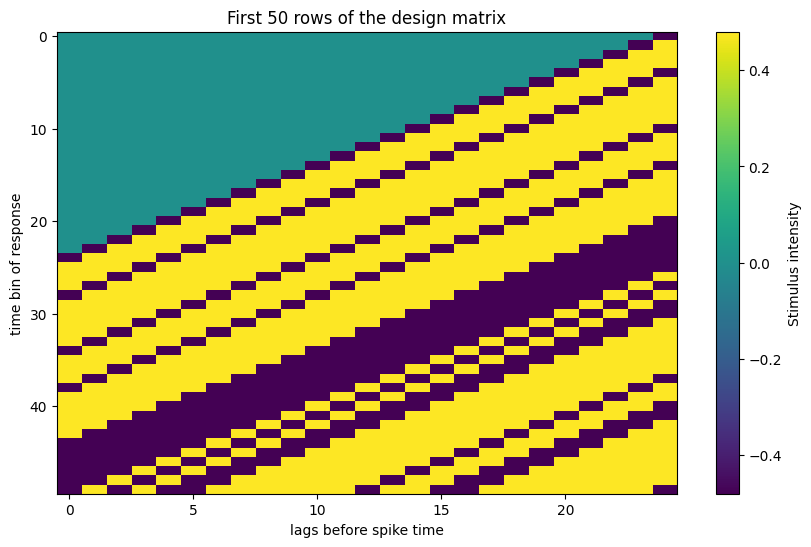

In [10]:
# zero padding
Stim_padded = np.vstack((np.zeros((24,1)), Stim))

# create design matrix
X = Stim_padded[0:len(Stim)]
for i in range(1, 25):
    X = np.hstack((X, Stim_padded[i:len(Stim)+i]))
    
# Plot the first 50 rows of the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(X[:50, :], aspect='auto', cmap='viridis')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar(label='Stimulus intensity')
plt.title('First 50 rows of the design matrix')
plt.show()

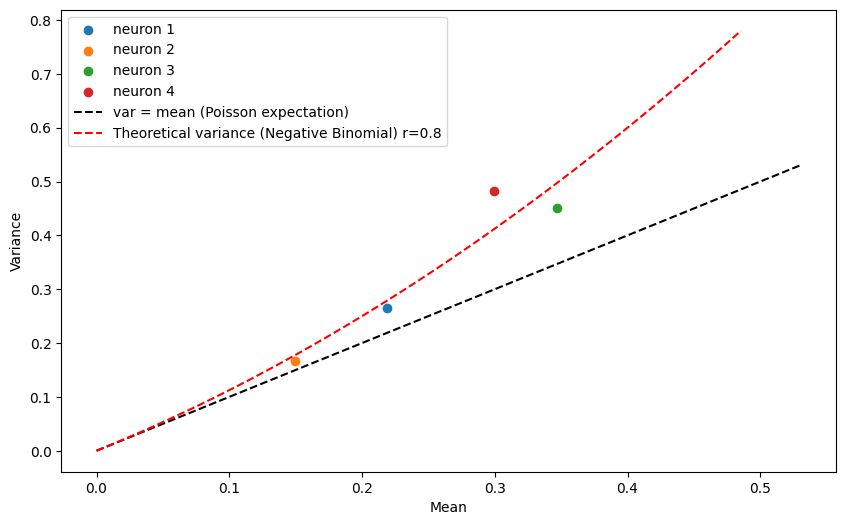

In [11]:
means = np.mean(SpCounts, axis=0)
variances = np.var(SpCounts, axis=0)

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.scatter(means[i], variances[i], label=f'neuron {i+1}')
    
max_val = np.max([means.max(), variances.max()]) * 1.1  # Slightly larger than the max value for good measure
plt.plot([0, max_val], [0, max_val], 'k--', label='var = mean (Poisson expectation)')


dispersion = 0.8
mu_values = np.linspace(0, np.max(means)*1.4, 400)
p = dispersion / (dispersion + mu_values)
expected_variance = dispersion * (1-p)/p**2
plt.plot(mu_values, expected_variance, 'r--', label='Theoretical variance (Negative Binomial) r=0.8')

plt.xlabel('Mean')
plt.ylabel('Variance')

plt.legend()

In [12]:
STA = X.T @ SpCounts[:, 3] / np.sum(SpCounts[:, 3])
X_augmented = np.hstack((X, np.ones((X.shape[0], 1))))

Y = SpCounts[:, 3]

# linear-gaussian GLM
w = np.linalg.inv(X_augmented.T @ X_augmented) @ X_augmented.T @ Y

# Rescale to be unit vectors
w_rescaled = w / np.linalg.norm(w)
STA_rescaled = STA / np.linalg.norm(STA)

In [13]:
import numpy as np
from scipy.optimize import minimize

def neg_log_likelihood(w, Y, X):
    z = dtStim*np.exp(X @ w)
    return -np.sum(Y * np.log(z) - z)

# Initial guess for w
w0 = np.zeros(X_augmented.shape[1])

# Use scipy.optimize.minimize to find w that minimizes neg_log_likelihood
result = minimize(neg_log_likelihood, w0, args=(Y, X_augmented))

# The maximum-likelihood estimate for w is stored in result.x
possion_GLM_mle = result.x

possion_GLM_mle_rescaled = possion_GLM_mle / np.linalg.norm(possion_GLM_mle)

print(f"Poission custom negative log-likelihood: {result.fun}")

Poission custom negative log-likelihood: 44892.53872159704


In [14]:
sm_poission_GLM_results = sm_fit_model_poission_exp(X_augmented, Y)
print(f"sm.poisson negative log-likelihood: {-sm_poission_GLM_results.llf}")

sm.poisson negative log-likelihood: 57484.71038249701


In [15]:
def neg_binomial_loglik(params, X, y):
    beta = params[:-1]
    log_dispersion = params[-1]
    dispersion = np.exp(log_dispersion)
    
    p = expit((X @ beta))
    epsilon = 1e-10
        
    term1 = gammaln(y + dispersion) - gammaln(dispersion) - gammaln(y + 1)
    term2 = dispersion * np.log(1 - p + epsilon)
    term3 = y * np.log(p + epsilon)
    
    return -np.sum(term1 + term2 + term3)

def fit_NB_full_model(X, y):
    init_params = np.append(np.zeros(X.shape[1]), np.log(0.5)) # Last one is log(dispersion)

    # Minimize the negative log likelihood
    result = minimize(neg_binomial_loglik, init_params, args=(X, y))
    
    return result

NB_result = fit_NB_full_model(X_augmented, Y)
NB_GLM_mle = NB_result.x

NB_GLM_mle_rescaled = NB_GLM_mle[:-2] / np.linalg.norm(NB_GLM_mle[:-2])
print(f"Dispersion parameter: {np.exp(NB_result.x[-1])}")
print(f"NB custom negative log-likelihood: {NB_result.fun}")

Dispersion parameter: 4109.175952258158
NB custom negative log-likelihood: 57485.98474272051


In [16]:
sm_NB_GLM_results = sm_fit_model_NB_logistic(X_augmented, Y, alpha=1.25)
sm_NB_GLM_mle_rescaled = sm_NB_GLM_results.params / np.linalg.norm(sm_NB_GLM_results.params)
print(f"sm.NB negative log-likelihood: {-sm_NB_GLM_results.llf}")

sm.NB negative log-likelihood: 64331.869848595656


In [17]:
sm_poission_GLM_results.params[:-1]

array([-0.08044706, -0.09878433, -0.08291872, -0.09791463, -0.08777722,
       -0.090324  , -0.09348104, -0.09090708, -0.07830959, -0.07947624,
       -0.08372249, -0.15656615, -0.2339567 , -0.23743685, -0.16356788,
       -0.17827876, -0.42762929, -0.90279443, -0.64860472,  1.43775449,
        3.56555438,  1.57978993,  0.344327  ,  0.02140719,  0.00420574])

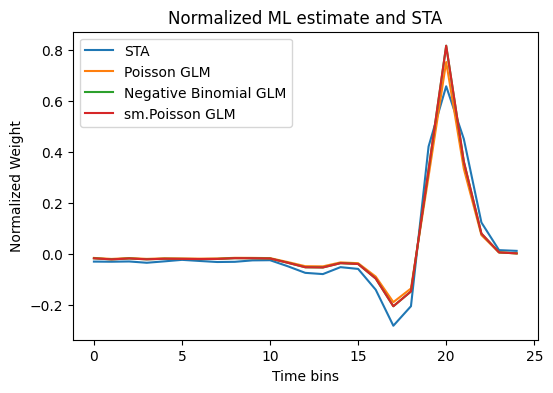

In [18]:
# Plot the rescaled ML filter estimate and the STA
plt.figure(figsize=(6, 4))

# plt.plot(w_rescaled[:-1], label='Linear-Gaussian GLM')

plt.plot(STA_rescaled, label='STA')

plt.plot(possion_GLM_mle_rescaled[:-1], label='Poisson GLM')

plt.plot(NB_GLM_mle_rescaled, label='Negative Binomial GLM')

plt.plot(sm_poission_GLM_results.params[:-1] / np.linalg.norm(sm_poission_GLM_results.params[:-1]), label='sm.Poisson GLM')


plt.xlabel('Time bins')
plt.ylabel('Normalized Weight')
plt.legend()
plt.title('Normalized ML estimate and STA')
plt.show()

# Other


In [19]:
import numpy as np
from scipy.special import expit

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
T = 1000  # Number of time bins
n_cells = 100  # Number of retinal ganglion cells (RGCs)
dt_stim = 1 / 120  # Size of a single time bin (in seconds)

num_of_ons = 100

stim = np.zeros(T)

count = 0
for i in range(T):
    if count == 10:
        stim[i] = 0.5
        count = 0
    else:
        stim[i] = -0.5
        count += 1

# Define the relationship between stimulus intensity and spike count
def stimulus_to_spike_count(stim, beta, dispersion):
    # Assume a linear relationship between stimulus intensity and log mean spike count
    log_mean_spike_count = beta[0] + beta[1] * stim
    mean_spike_count = np.exp(log_mean_spike_count)
    
    # Calculate probability of success for negative binomial distribution
    p = dispersion / (dispersion + mean_spike_count)
            
    # Sample spike counts from negative binomial distribution
    spike_count = np.random.negative_binomial(dispersion, p)
    
    return spike_count

# Set parameters for each RGC
beta_params = [0, 3]
dispersion = 3  # Varied dispersion parameters for each RGC

# Generate spike counts for each RGC
sp_counts = np.zeros((T, n_cells))
for i in range(n_cells):
    for t in range(T):
        sp_counts[t, i] = stimulus_to_spike_count(stim[t], beta_params, dispersion)

# Create the dataset dictionary
dataset = {
    'Stim': stim,
    'SpCounts': sp_counts,
    'dtStim': dt_stim
}

In [20]:
Stim = dataset['Stim'].reshape(-1, 1)
SpCounts = dataset['SpCounts']

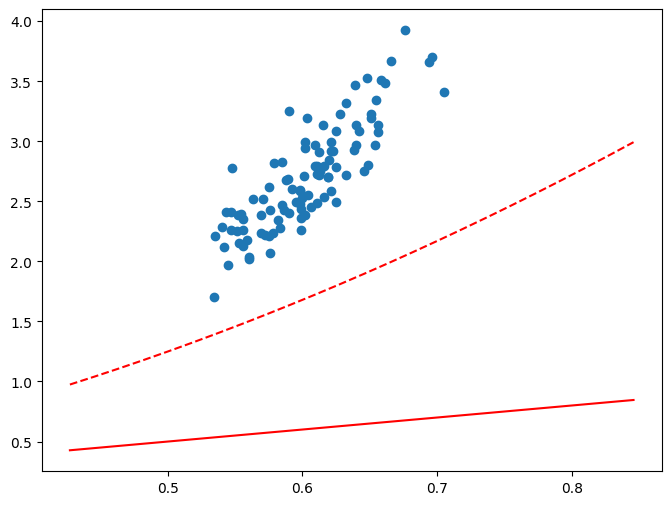

In [21]:
sp_mean = SpCounts.mean(axis=0)
sp_var = SpCounts.var(axis=0)

# find dispersion parameter of the dataset
true_dispersion = (sp_mean ** 2) / (sp_var - sp_mean)
true_dispersion = true_dispersion.mean()

plt.figure(figsize=(8, 6))

# use original dispersion parameter
nb_dispersion = 1/dispersion
mu_values = np.linspace(np.min(sp_mean)*0.8, np.max(sp_mean)*1.2, 300)
p = nb_dispersion / (nb_dispersion + mu_values)
expected_variance = nb_dispersion*(1-p)/p**2
plt.plot(mu_values, expected_variance, 'r--', label='Theoretical variance (Negative Binomial)')

plt.scatter(sp_mean, sp_var, label='Data')

# Theoretical variance curve for Poisson distribution
plt.plot(mu_values, mu_values, label='Poisson expectation', color='red') 

In [22]:
true_dispersion

0.1765891072000377

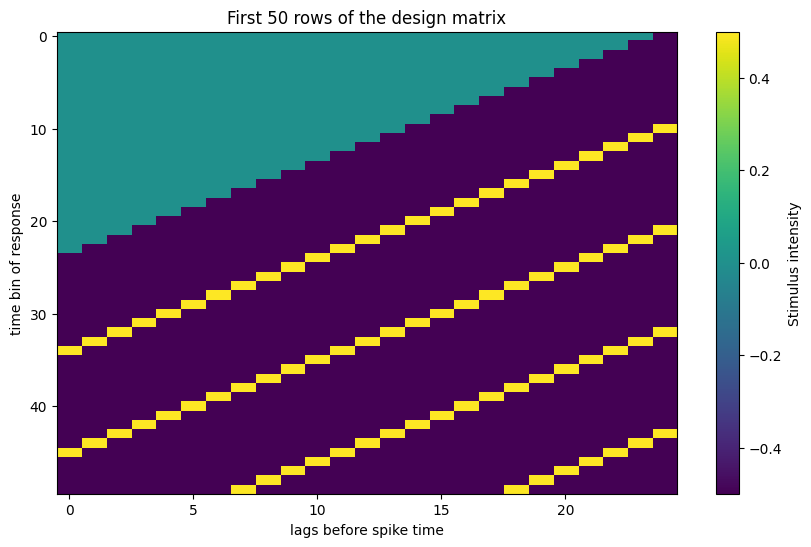

In [23]:
# zero padding
Stim_padded = np.vstack((np.zeros((24,1)), Stim))

# create design matrix
X = Stim_padded[0:len(Stim)]
for i in range(1, 25):
    X = np.hstack((X, Stim_padded[i:len(Stim)+i]))
    
# Plot the first 50 rows of the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(X[:50, :], aspect='auto', cmap='viridis')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar(label='Stimulus intensity')
plt.title('First 50 rows of the design matrix')
plt.show()

In [24]:
X_augmented = np.hstack((X, np.ones((X.shape[0], 1))))

spike-triggered average for neuron 1: [-0.45348837 -0.46013289  0.15780731 -0.44850498 -0.45930233 -0.47591362
 -0.46096346 -0.46262458 -0.47425249 -0.46096346 -0.45930233 -0.4576412
 -0.46428571  0.160299   -0.44850498 -0.46179402 -0.47840532 -0.46345515
 -0.46511628 -0.47674419 -0.46345515 -0.46179402 -0.46179402 -0.46843854
  0.15780731]


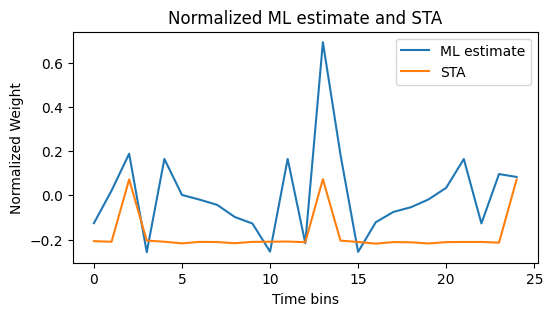

Difference between the STA and the ML estimate: 1.1948524039562383


In [25]:
STA = X.T @ SpCounts[:, 0] / np.sum(SpCounts[:, 0])
print(f"spike-triggered average for neuron 1: {STA}")

# Compute the maximum likelihood estimate for the linear-Gaussian GLM
# aka least squares
Y = SpCounts[:, 0]
w = np.linalg.inv(X_augmented.T @ X_augmented) @ X_augmented.T @ Y

# Rescale the ML filter estimate and the STA to be unit vectors
w_rescaled = w / np.linalg.norm(w)
STA_rescaled = STA / np.linalg.norm(STA)

# Plot the rescaled ML filter estimate and the STA
plt.figure(figsize=(6, 3))
plt.plot(w_rescaled[:-1], label='ML estimate')
plt.plot(STA_rescaled, label='STA')
plt.xlabel('Time bins')
plt.ylabel('Normalized Weight')
plt.legend()
plt.title('Normalized ML estimate and STA')
plt.show()

difference = np.linalg.norm(STA_rescaled - w_rescaled[:-1])
print(f"Difference between the STA and the ML estimate: {difference}")

In [26]:
from scipy.special import gammaln, expit
from scipy.optimize import minimize

def neg_binomial_loglik(params, X, y):
    beta = params[:-1]
    alpha = params[-1]
    
    alpha = np.exp(alpha)
    
    mu = expit(X @ beta)
        
    term1 = gammaln(y + alpha) - gammaln(alpha) - gammaln(y + 1)
    term2 = (alpha) * np.log(alpha / (alpha + mu))
    term3 = y * np.log(mu / (alpha + mu))
    
    return -np.sum(term1 + term2 + term3)

def fit_model(X, y):
    # Initial guess for parameters
    init_params = np.append(np.zeros(X.shape[1]), 1) # Last one is log(alpha)

    # Minimize the negative log likelihood
    result = minimize(neg_binomial_loglik, init_params, args=(X, y))

    if result.success:
        fitted_params = result
        print("Model fitted successfully.")
    else:
        fitted_params = result
        print("Failed fitting")

    return result

In [27]:
please = fit_model(X, SpCounts[:, 0])
please

Model fitted successfully.


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 851.7453850727446
        x: [ 2.272e+01  5.150e+01 ...  3.204e+02 -4.895e-01]
      nit: 66
      jac: [ 0.000e+00 -7.629e-06 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 2.664e+03  1.664e+02 ...  5.159e+01 -8.339e-02]
            [ 1.664e+02  1.113e+01 ...  3.339e+00 -2.827e-03]
            ...
            [ 5.159e+01  3.339e+00 ...  2.370e+00  2.918e-02]
            [-8.339e-02 -2.827e-03 ...  2.918e-02  1.370e-02]]
     nfev: 2700
     njev: 100

In [28]:
please.x

array([  22.72388129,   51.4989538 , -245.83153334, -471.78796509,
        214.91458851,  109.11094915,   46.0692782 ,  -22.41113616,
       -109.72083636, -181.68329677, -275.85886078,  194.7373291 ,
         94.61870588,  208.77903184,  437.16108983, -249.87644656,
       -144.81805491,  -81.09246923,  -12.67544489,   74.10684566,
        146.66010456,  240.89700318, -252.34831065, -181.25553405,
        320.38571396,   -0.48947949])

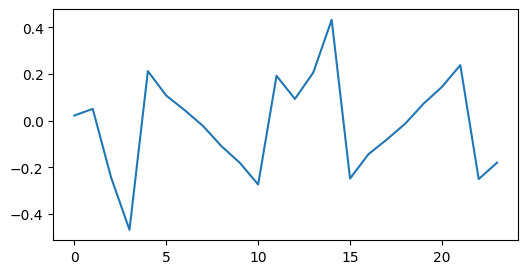

In [29]:
w_mle_rescaled = please.x[:-2] / np.linalg.norm(please.x[:-2])

plt.figure(figsize=(6, 3))
plt.plot(w_mle_rescaled)